### Loading Preprocessed Data

In [23]:
import os
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.api.models import Sequential, Model
from keras.api.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Input, Concatenate, LSTM, Bidirectional, Dot, Flatten, Layer, Activation, MultiHeadAttention, LayerNormalization
from keras.api.optimizers import Adam, SGD
from keras.api.optimizers.schedules import ExponentialDecay, CosineDecay
from keras.api.callbacks import LearningRateScheduler, Callback, ReduceLROnPlateau
from sklearn.metrics import classification_report, accuracy_score, precision_recall_curve, average_precision_score, roc_curve, auc
import matplotlib.pyplot as plt
import math

In [24]:
# Load training and test data from directories
def load_data_from_directory(directory):
    data = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".json"):
                with open(os.path.join(root, file), 'r') as f:
                    entry = json.load(f)
                    data.append((entry["tokens"], entry["label"]))
    return data

# Load and combine training data
print("Loading training data...")
train_data = load_data_from_directory("vuln_train") + load_data_from_directory("patched_train")
X_train_full = [entry[0] for entry in train_data]  # Token sequences
y_train_full = [entry[1] for entry in train_data]  # Labels

# Load and combine test data
print("Loading test data...")
test_data = load_data_from_directory("vuln_test") + load_data_from_directory("patched_test")
X_test = [entry[0] for entry in test_data]
y_test = [entry[1] for entry in test_data]

# Build vocabulary from training data
print("Building vocabulary...")
vocab = {"<PAD>": 0, "<UNK>": 1}
current_id = 2
for sequence in X_train_full:
    for token in sequence:
        if token not in vocab:
            vocab[token] = current_id
            current_id += 1

vocab_size = len(vocab)
unk_id = vocab["<UNK>"]

# Save vocabulary
with open("training_vocab.json", "w") as vocab_file:
    json.dump(vocab, vocab_file)
print(f"Vocabulary size: {vocab_size}")

# Encode sequences with vocabulary
def encode_sequences(sequences, vocab, max_length):
    encoded = []
    for sequence in sequences:
        encoded_sequence = [vocab.get(token, unk_id) for token in sequence]
        # Pad or truncate to max_length
        if len(encoded_sequence) > max_length:
            encoded_sequence = encoded_sequence[:max_length]
        else:
            encoded_sequence += [vocab["<PAD>"]] * (max_length - len(encoded_sequence))
        encoded.append(encoded_sequence)
    return np.array(encoded)

# Determine the max sequence length
max_length = max(max(len(seq) for seq in X_train_full), max(len(seq) for seq in X_test))
print(f"Max sequence length: {max_length}")

# Encode training, validation, and test data
X_train_full_encoded = encode_sequences(X_train_full, vocab, max_length)
X_test_encoded = encode_sequences(X_test, vocab, max_length)

# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full_encoded, np.array(y_train_full), test_size=0.2, random_state=42
)
y_test = np.array(y_test)

print("Data preparation complete.")
print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test_encoded.shape}")


Loading training data...
Loading test data...
Building vocabulary...
Vocabulary size: 8
Max sequence length: 1941
Data preparation complete.
Training set: (1312, 1941), Validation set: (328, 1941), Test set: (82, 1941)


### Defining CNN Model

In [25]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, embedding_dim):
        super(PositionalEncoding, self).__init__()
        self.embedding_dim = embedding_dim

    def call(self, inputs):
        seq_length = tf.shape(inputs)[1]  # Get the dynamic sequence length
        position = tf.range(seq_length, dtype=tf.float32)[:, tf.newaxis]
        div_term = tf.exp(tf.range(0, self.embedding_dim, 2, dtype=tf.float32) * -(np.log(10000.0) / self.embedding_dim))
        positional_encoding = tf.concat([tf.sin(position * div_term), tf.cos(position * div_term)], axis=1)
        positional_encoding = positional_encoding[tf.newaxis, ...]
        return inputs + positional_encoding[:, :seq_length, :]

def transformer_encoder(inputs, num_heads, key_dim, ff_dim, dropout_rate):
    # Multi-Head Self Attention
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(inputs, inputs)
    attention = Dropout(dropout_rate)(attention)
    attention = LayerNormalization(epsilon=1e-6)(inputs + attention)

    # Feed Forward Network
    ff_output = Dense(ff_dim, activation="relu")(attention)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    return LayerNormalization(epsilon=1e-6)(attention + ff_output)

def build_cnn_model(vocab_size, embedding_dim=256, num_filters=256, kernel_sizes=[3, 5, 7],
                    lstm_units=256, dense_units=256, dropout_rate=0.5, l2_lambda=0.01, num_heads=4):
    """
    Builds an advanced CNN-BiLSTM hybrid model with attention, positional encoding, and transformer encoder layers.

    Args:
        vocab_size (int): Size of the vocabulary.
        embedding_dim (int): Dimension of embedding vectors.
        num_filters (int): Number of filters in Conv1D layers.
        kernel_sizes (list): List of kernel sizes for Conv1D layers.
        lstm_units (int): Number of LSTM units in the Bidirectional LSTM layer.
        dense_units (int): Number of units in the fully connected Dense layer.
        dropout_rate (float): Dropout rate for regularization.
        l2_lambda (float): L2 regularization factor.
        num_heads (int): Number of attention heads in the transformer encoder layer.

    Returns:
        keras.Model: Compiled advanced model.
    """
    input_layer = Input(shape=(None,), dtype="int32")  # Variable-length sequences

    # Embedding Layer
    embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True)(input_layer)

    # Positional Encoding
    positional_encoding_layer = PositionalEncoding(embedding_dim=embedding_dim)
    embedding_with_positional_encoding = positional_encoding_layer(embedding)

    # Transformer Encoder Layer
    transformer = transformer_encoder(embedding_with_positional_encoding, num_heads=num_heads, key_dim=embedding_dim, ff_dim=512, dropout_rate=0.1)

    # Convolutional Layers with Multiple Kernel Sizes
    conv_layers = []
    for kernel_size in kernel_sizes:
        conv = Conv1D(
            filters=num_filters,
            kernel_size=kernel_size,
            activation="relu",
            kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)
        )(transformer)
        pooled = GlobalMaxPooling1D()(conv)
        conv_layers.append(pooled)

    # Concatenate Features from Convolutional Layers
    conv_features = Concatenate()(conv_layers)

    # Bidirectional LSTM for Contextual Understanding
    lstm = Bidirectional(LSTM(
        lstm_units,
        return_sequences=True,
        kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)
    ))(transformer)

    # Attention Mechanism
    attention = Dense(1, activation="tanh")(lstm)
    attention = tf.keras.layers.Flatten()(attention)
    attention_weights = tf.keras.layers.Activation("softmax")(attention)
    attention_output = tf.keras.layers.Dot(axes=1)([attention_weights, lstm])

    # Combine Features from CNN and LSTM with Attention
    combined = Concatenate()([conv_features, attention_output])

    # Fully Connected Layers
    dense = Dense(dense_units, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l2_lambda))(combined)
    dropout = Dropout(dropout_rate)(dense)

    # Output Layer for Binary Classification
    output = Dense(1, activation="sigmoid")(dropout)

    # Build Model
    model = Model(inputs=input_layer, outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
    )
    return model



### Training CNN

/home/willt/classes/csce704/csce704/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'conv1d_3' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/willt/classes/csce704/csce704/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'conv1d_4' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/willt/classes/csce704/csce704/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'conv1d_5' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream 

Training with Cyclical Learning Rate...
Epoch 1/10


I0000 00:00:1732962477.235654  104232 cuda_dnn.cc:529] Loaded cuDNN version 90300


41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.4934 - loss: 10.7829 - val_accuracy: 0.4390 - val_loss: 10.7851 - learning_rate: 1.0000e-05
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.5284 - loss: 10.7785 - val_accuracy: 0.4390 - val_loss: 10.7833 - learning_rate: 1.0495e-05
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.5180 - loss: 10.7774 - val_accuracy: 0.4390 - val_loss: 10.7815 - learning_rate: 1.0990e-05
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.4921 - loss: 10.7774 - val_accuracy: 0.4390 - val_loss: 10.7796 - learning_rate: 1.1485e-05
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.4838 - loss: 10.7763 - val_accuracy: 0.4390 - val_loss: 10.7777 - learning_rate: 1.1980e-05
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.5290 - loss: 10.7723 - val_accuracy: 0.4390 - val_loss: 10.7756 - learning_rate: 1.2475e-05
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.5247

/home/willt/classes/csce704/csce704/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'conv1d_6' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/willt/classes/csce704/csce704/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'conv1d_7' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/willt/classes/csce704/csce704/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'conv1d_8' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream 

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.5084 - loss: 10.7452 - val_accuracy: 0.4390 - val_loss: 10.6424
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.5290 - loss: 10.5973 - val_accuracy: 0.4390 - val_loss: 10.4805
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.5218 - loss: 10.4347 - val_accuracy: 0.4390 - val_loss: 10.3215
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.5366 - loss: 10.2769 - val_accuracy: 0.4390 - val_loss: 10.1624
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.5127 - loss: 10.1214 - val_accuracy: 0.4390 - val_loss: 10.0087
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.5256 - loss: 9.9677 - val_accuracy: 0.4390 - val_loss: 9.8573
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.5110 - loss: 9.8162 - val_accuracy: 0.4390 - val_loss: 9.7085
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.5415 - loss: 9.6642 - val_accuracy: 0.4390 - va

/home/willt/classes/csce704/csce704/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'conv1d_9' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/willt/classes/csce704/csce704/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'conv1d_10' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/willt/classes/csce704/csce704/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'conv1d_11' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstrea

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.5502 - loss: 10.5291 - val_accuracy: 0.4390 - val_loss: 9.5314 - learning_rate: 0.0100
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.5295 - loss: 9.1705 - val_accuracy: 0.4360 - val_loss: 8.1692 - learning_rate: 0.0100
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.5391 - loss: 7.8665 - val_accuracy: 0.4390 - val_loss: 7.0219 - learning_rate: 0.0100
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.5346 - loss: 6.7619 - val_accuracy: 0.4390 - val_loss: 6.0488 - learning_rate: 0.0100
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.5143 - loss: 5.8273 - val_accuracy: 0.4390 - val_loss: 5.2225 - learning_rate: 0.0100
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.5448 - loss: 5.0341 - val_accuracy: 0.5854 - val_loss: 4.5212 - learning_rate: 0.0100
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.5313 - loss: 4.3683 - val_accuracy: 0.4

/home/willt/classes/csce704/csce704/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'conv1d_12' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/willt/classes/csce704/csce704/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'conv1d_13' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/home/willt/classes/csce704/csce704/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'conv1d_14' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstre

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.4514 - loss: 10.7597 - val_accuracy: 0.5610 - val_loss: 10.7535 - learning_rate: 1.0000e-05
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.4865 - loss: 10.7517 - val_accuracy: 0.5610 - val_loss: 10.7268 - learning_rate: 2.0800e-04
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.4633 - loss: 10.7171 - val_accuracy: 0.5457 - val_loss: 10.6681 - learning_rate: 4.0600e-04
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.5271 - loss: 10.6473 - val_accuracy: 0.4421 - val_loss: 10.5784 - learning_rate: 6.0400e-04
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.5163 - loss: 10.5476 - val_accuracy: 0.4390 - val_loss: 10.4572 - learning_rate: 8.0200e-04
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.5265 - loss: 10.4180 - val_accuracy: 0.4390 - val_loss: 10.3064 - learning_rate: 0.0010
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.5339 - l

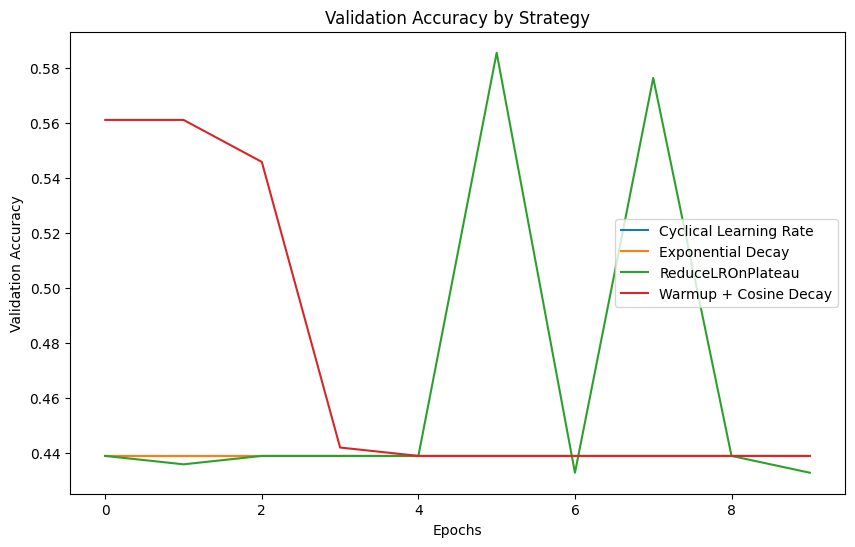

In [4]:
# Define the exponential decay learning rate schedule
def exponential_decay_schedule():
    return ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=1000,
        decay_rate=0.96,
        staircase=True
    )

# Define the warmup with cosine decay learning rate schedule
def warmup_cosine_decay_schedule(epoch):
    if epoch < 5:  # Warmup phase
        return float(1e-5 + (epoch / 5) * (1e-3 - 1e-5))  # Python float
    else:  # Cosine decay phase
        decay = CosineDecay(initial_learning_rate=1e-3, decay_steps=15)
        return float(decay(epoch - 5))  # Python float

# Cyclical Learning Rate
def cyclical_learning_rate_schedule(base_lr=1e-5, max_lr=1e-3, step_size=2000):
    def lr_schedule(batch):
        cycle = math.floor(1 + batch / (2 * step_size))
        x = abs(batch / step_size - 2 * cycle + 1)
        lr = base_lr + (max_lr - base_lr) * max(0, (1 - x))
        return float(lr)  # Ensure the return value is a Python float
    return lr_schedule

# Train with ReduceLROnPlateau
def train_with_reduce_lr():
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )
    return None, [reduce_lr]

# Train with Exponential Decay
def train_with_exponential_decay():
    lr_schedule = exponential_decay_schedule()
    optimizer = SGD(learning_rate=lr_schedule, momentum=0.9)
    return optimizer, []

# Train with Warmup + Cosine Decay
def train_with_warmup_cosine_decay():
    lr_scheduler = LearningRateScheduler(warmup_cosine_decay_schedule)
    return None, [lr_scheduler]

# Train with Cyclical Learning Rate
def train_with_cyclical_lr(base_lr=1e-5, max_lr=1e-3, step_size=2000):
    lr_schedule = cyclical_learning_rate_schedule(base_lr, max_lr, step_size)
    lr_scheduler = LearningRateScheduler(lr_schedule)
    return None, [lr_scheduler]

# Function to train the model with a specific strategy
def train_with_strategy(strategy_name, optimizer=None, callbacks=[]):
    print(f"Training with {strategy_name}...")

    # Use default SGD optimizer if not provided
    if not optimizer:
        optimizer = SGD(learning_rate=0.01, momentum=0.9)

    # Build and compile the model
    model = build_cnn_model(vocab_size=vocab_size, embedding_dim=128)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )
    return history

# Execute strategies
strategies = {
    "Cyclical Learning Rate": train_with_cyclical_lr(),
    "Exponential Decay": train_with_exponential_decay(),
    "ReduceLROnPlateau": train_with_reduce_lr(),
    "Warmup + Cosine Decay": train_with_warmup_cosine_decay()
}

history_records = {}

for strategy_name, (optimizer, callbacks) in strategies.items():
    history = train_with_strategy(strategy_name, optimizer=optimizer, callbacks=callbacks)
    history_records[strategy_name] = history

# Plot validation accuracy
plt.figure(figsize=(10, 6))
for strategy_name, history in history_records.items():
    plt.plot(history.history['val_accuracy'], label=strategy_name)
plt.title("Validation Accuracy by Strategy")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.show()


### Best Learning Rate Method

In [28]:
# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6
)

# Build the model
cnn_model = build_cnn_model(
    vocab_size=vocab_size,
    embedding_dim=256,
    num_filters=256,
    kernel_sizes=[3, 5, 7],
    lstm_units=256,
    dense_units=256,
    dropout_rate=0.5,
    l2_lambda=0.01,
    num_heads=4
)

# Train the model
history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    callbacks=[early_stopping, reduce_lr_callback],
    verbose=1
)

# Evaluate the model on the test set
test_results = cnn_model.evaluate(X_test_encoded, y_test, verbose=1)
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")
print(f"Test AUC: {test_results[2]:.4f}")

# Save the trained model
model_path = "advanced_cnn_bilstm_model.keras"
cnn_model.save(model_path)
print(f"Model saved to '{model_path}'.")


Epoch 1/50


/home/willt/classes/csce704/csce704/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'positional_encoding_4' (of type PositionalEncoding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


82/82 ━━━━━━━━━━━━━━━━━━━━ 56s 631ms/step - accuracy: 0.4963 - auc: 0.4891 - loss: 20.3643 - val_accuracy: 0.5610 - val_auc: 0.5229 - val_loss: 17.2923 - learning_rate: 1.0000e-04
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 51s 626ms/step - accuracy: 0.4730 - auc: 0.4722 - loss: 16.5479 - val_accuracy: 0.4390 - val_auc: 0.5000 - val_loss: 14.3518 - learning_rate: 1.0000e-04
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 51s 627ms/step - accuracy: 0.4822 - auc: 0.4773 - loss: 13.7089 - val_accuracy: 0.4390 - val_auc: 0.5000 - val_loss: 11.9028 - learning_rate: 1.0000e-04
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 51s 627ms/step - accuracy: 0.5271 - auc: 0.5024 - loss: 11.3662 - val_accuracy: 0.4390 - val_auc: 0.5000 - val_loss: 9.8929 - learning_rate: 1.0000e-04
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 51s 626ms/step - accuracy: 0.4890 - auc: 0.4877 - loss: 9.4651 - val_accuracy: 0.4390 - val_auc: 0.5000 - val_loss: 8.2697 - learning_rate: 1.0000e-04
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 52s 630ms/step - accu

KeyboardInterrupt: 

### Evaluating Model

In [13]:
# Evaluate the model
test_predictions = cnn_model.predict(X_test_encoded)
test_predictions_binary = (test_predictions > 0.5).astype(int)

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, test_predictions_binary))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.66      0.57        41
           1       0.50      0.34      0.41        41

    accuracy                           0.50        82
   macro avg       0.50      0.50      0.49        82
weighted avg       0.50      0.50      0.49        82



### Testing

In [14]:
# Predict on the test data
test_predictions = cnn_model.predict(X_test_encoded, verbose=1)
test_predictions_binary = (test_predictions > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate overall accuracy
accuracy = accuracy_score(y_test, test_predictions_binary)
print(f"Overall Accuracy: {accuracy * 100:.2f}%")

# Save the trained model
model_path = "cnn_vulnerability_detector.keras"
cnn_model.save(model_path)
print(f"Model saved to '{model_path}'.")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Overall Accuracy: 50.00%
Model saved to 'cnn_vulnerability_detector.keras'.


### Graphs

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


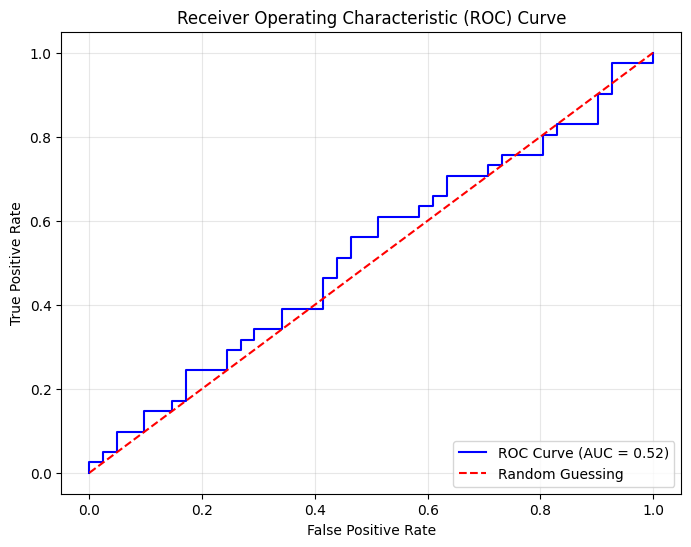

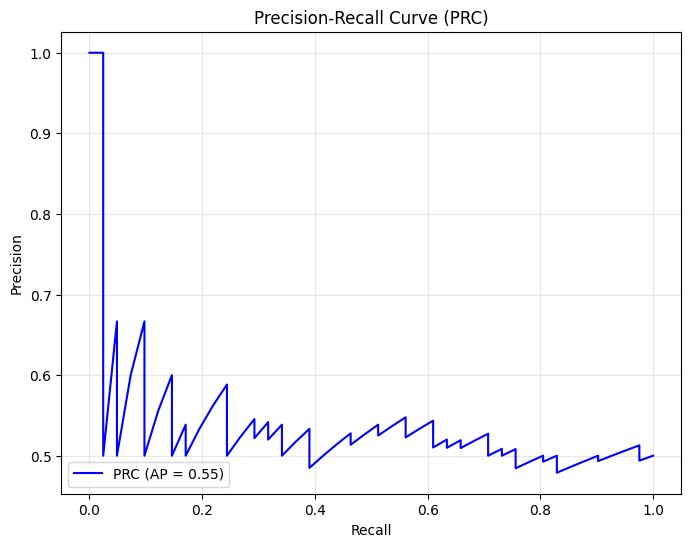

In [15]:
# Predict probabilities for the test set
test_probabilities = cnn_model.predict(X_test_encoded, verbose=1)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, test_probabilities)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Compute Precision-Recall curve and Average Precision Score
precision, recall, thresholds_prc = precision_recall_curve(y_test, test_probabilities)
average_precision = average_precision_score(y_test, test_probabilities)

# Plot the Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f'PRC (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (PRC)')
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.show()